In [46]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
!pip install lalsuite pycbc gwpy

In [48]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

In [49]:
merger = Merger("GW150914")

strain = merger.strain('H1')

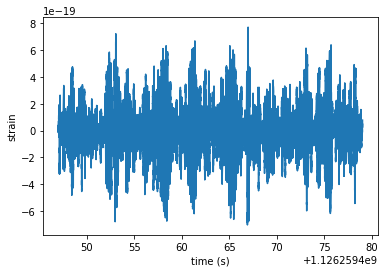

In [50]:
plt.plot(strain.sample_times, strain)
plt.xlabel('time (s)')
plt.ylabel('strain');

In [51]:
from IPython.display import Audio

In [52]:
Audio(strain, rate=strain.sample_rate)

In [53]:
strain = resample_to_delta_t(highpass(strain, 15.0), 1./2048).crop(2, 2)

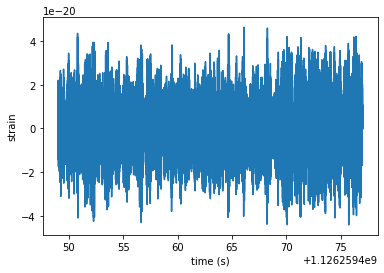

In [54]:
plt.plot(strain.sample_times, strain)
plt.xlabel('time (s)')
plt.ylabel('strain');

In [55]:
Audio(strain, rate=strain.sample_rate)

In [56]:
f_lower = 20.
f_upper = 1024.

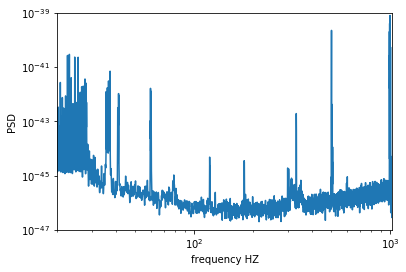

In [57]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = strain.psd(4)
psd = interpolate(psd, strain.delta_f)

psd = inverse_spectrum_truncation(psd, 4*strain.sample_rate)

fs = psd.delta_f*np.arange(psd.data.size)

plt.loglog(fs,psd)
plt.xlim(f_lower, f_upper)
plt.xlabel('frequency HZ')
plt.ylabel('PSD')
plt.ylim(1e-47, 1e-39);

In [58]:
from pycbc import filter
from pycbc.types import Array

from pycbc.waveform import get_td_waveform

In [59]:
m = 36. #solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                        mass1 = m,
                        mass2 = m,
                        delta_t = strain.delta_t,
                        f_lower=20)


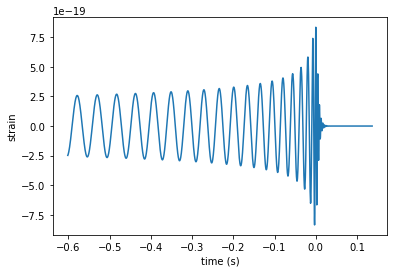

In [60]:
plt.plot(hp.sample_times, hp)
plt.xlabel('time (s)')
plt.ylabel('strain');
#keplers laws when they get closer they revolve quicker
#15 parameters to define which is pretty small

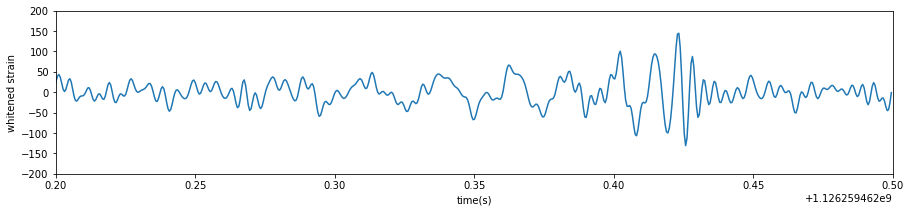

In [61]:
white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300,512)
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)


plt.figure(figsize=(15,3))
plt.plot(white_data.sample_times, white_data)
plt.xlabel('time(s)')
plt.ylabel('whitened strain')
plt.xlim(merger.time - 0.2, merger.time + .1)
plt.ylim(-200,200);

In [62]:
def gen_template(theta,
                 delta_t=strain.delta_t,
                 duration=strain.duration,
                 start_time=strain.start_time,
                 f_lower=f_lower):
    
    m, distance, time, phase = theta
    
    hp, hc = get_td_waveform(approximant='SEOBNRv4_opt',
                             mass1=m, mass2=m,
                             distance=distance,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)
    
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - strain.start_time)
    hp.start_time = strain.start_time
    
    return hp

In [63]:
df = strain.to_frequencyseries()

def loglikelihood(theta, df=df, f_lower=f_lower, f_upper=f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t=df.delta_t, f_lower=f_lower)
    hf = template.to_frequencyseries()
    
    kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)
    
    hh = np.array(4. * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax]).sum()
    dh = np.array(4. * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax]).sum()
    logl = -.5 * (hh - 2.*dh)
    return logl

In [64]:
def whiten_trim(template, psd=psd):
    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries()/psd**.5).to_timeseries()
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)
    
    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)
    return white_template

def plot_whitened_strains(strain, template):
    white_data = whiten_trim(strain)
    white_template = whiten_trim(template)
    
    plt.figure(figsize=(15, 3))
    plt.plot(white_data.sample_times, white_data, label='Data')
    plt.plot(white_template.sample_times, white_template, label='Template')
    plt.xlim(merger.time-.2, merger.time+.1)
    plt.legend()

-483.20305876227536


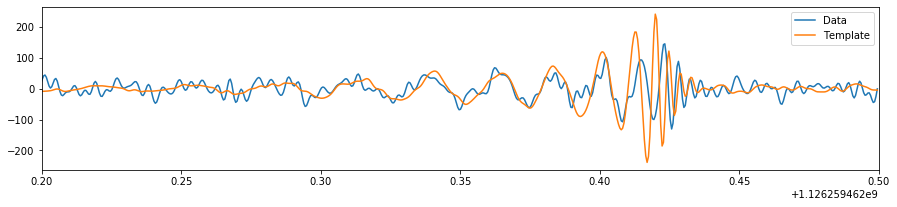

In [65]:
# m, distance, time, phase
theta0 = [36., 462., float(merger.time)+0.02, 0.]
template0 = gen_template(theta0)
plot_whitened_strains(strain, template0)

print(loglikelihood(theta0))

In [66]:
!pip install line_profiler

In [68]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [69]:
%lprun -f loglikelihood loglikelihood(theta0)

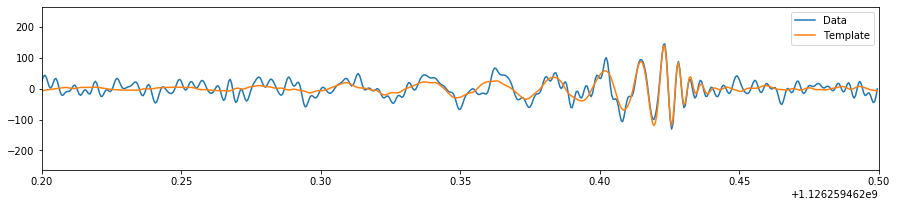

Steps	log(likelihood)
10	202.832


In [22]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize=[15, 3])
Neval = 1

whitened_template = whiten_trim(gen_template(theta0))

plt.plot(white_data.sample_times, white_data, label='Data')
line, = plt.plot(whitened_template.sample_times, whitened_template, label='Template')

plt.xlim(merger.time - .2, merger.time + .1)
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    template = gen_template(thetai)
    white_template = whiten_trim(template)
    line.set_ydata(white_template)
    
    clear_output(wait=True)
    display(fig)
    print('Steps\tlog(likelihood)')
    print('{}\t{:.3f}'.format(Neval, loglikelihood(thetai)))
    
    Neval += 1

res = minimize(lambda theta: -loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()


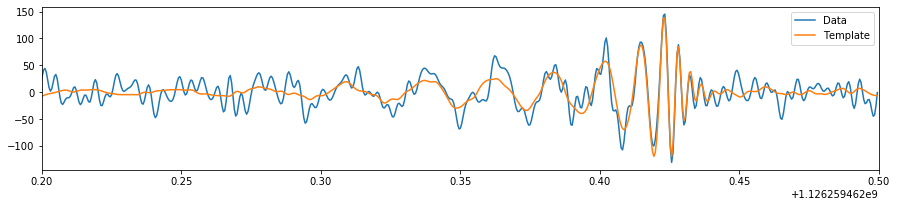

In [23]:
best_fit = res.x
best_fit_template = gen_template(best_fit)

plot_whitened_strains(strain, best_fit_template)

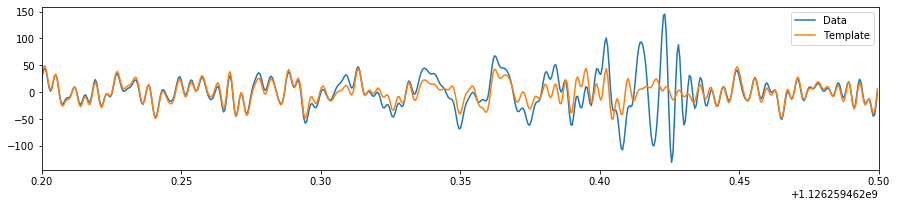

In [24]:
residuals = strain - best_fit_template

plot_whitened_strains(strain, residuals)

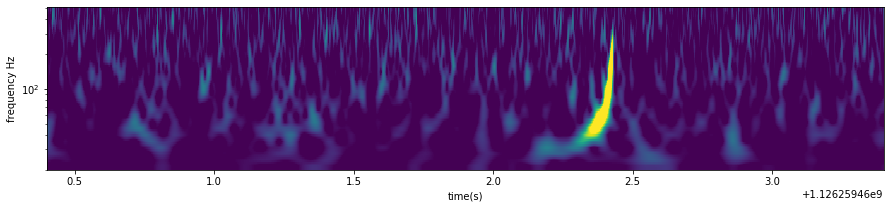

In [25]:
ws = strain.whiten(4,4)
t, f, p = ws.qtransform(0.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))
plt.figure(figsize=(15,3))
plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
plt.yscale('log')
plt.xlabel('time(s)')
plt.ylabel('frequency Hz')
plt.xlim(merger.time-2, merger.time+1);

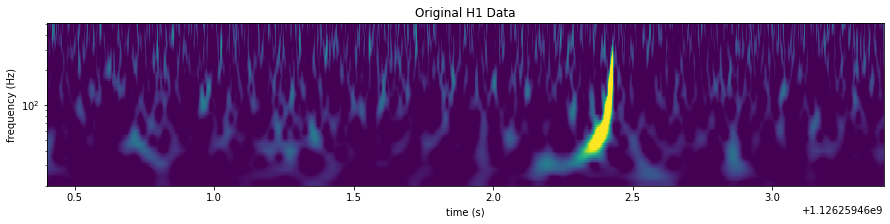

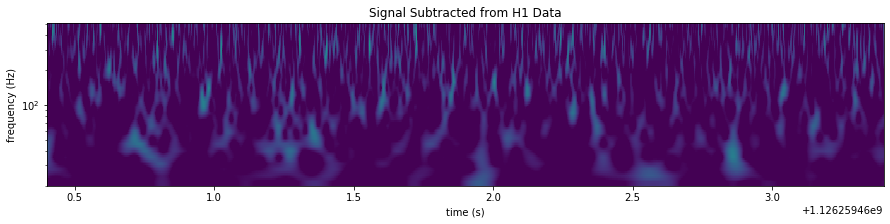

In [26]:
for data, title in [(strain, 'Original H1 Data'),
                    (residuals, 'Signal Subtracted from H1 Data')]:
    t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100,
                                           qrange=(8, 8), frange=(20, 512))
    plt.figure(figsize=[15, 3])
    plt.title(title)
    plt.pcolormesh(t, f, p**.5, vmin=1, vmax=6)
    plt.yscale('log')
    plt.xlabel('time (s)')
    plt.ylabel('frequency (Hz)')
    plt.xlim(merger.time - 2, merger.time + 1)

In [27]:
Audio(strain.whiten(4,4), rate=strain.sample_rate)

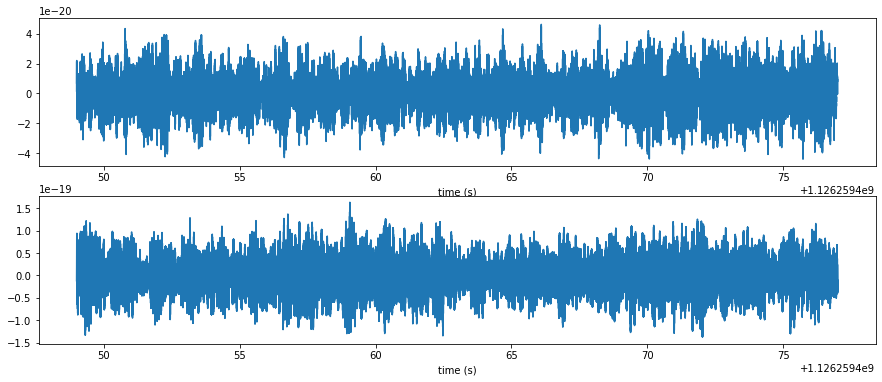

In [28]:
#Need to use both of the locations Hanford & Livingston to get position data

from pycbc.detector import Detector

dets = ['H1', 'L1']

strains = dict([(det, merger.strain(det)) for det in dets])

for det, strain in strains.items():
    strains[det] = resample_to_delta_t(highpass(strain, 15.0), 1./2048).crop(2, 2)
fig, axs = plt.subplots(2, 1, figsize=[15, 6])
for ax, det in zip(axs, dets):
    ax.plot(strains[det].sample_times, strains[det])
    ax.set_xlabel('time (s)')

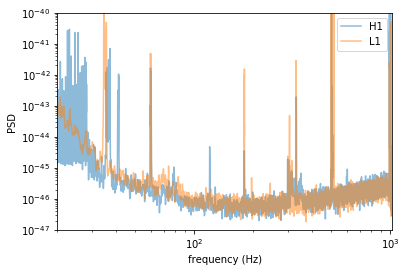

In [82]:
psds = {}

for det in dets:
    psd = strains[det].psd(4)
    psd = interpolate(psd, strains[det].delta_f)
    
    psds[det] = inverse_spectrum_truncation(psd, 4*strain.sample_rate)
    
fs = psd.delta_f * np.arange(psd.data.size)

for det in dets:
    plt.loglog(fs, psds[det], label=det, alpha=.5)
plt.xlim(f_lower, f_upper)
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.ylim(1e-47, 1e-40)
plt.legend();

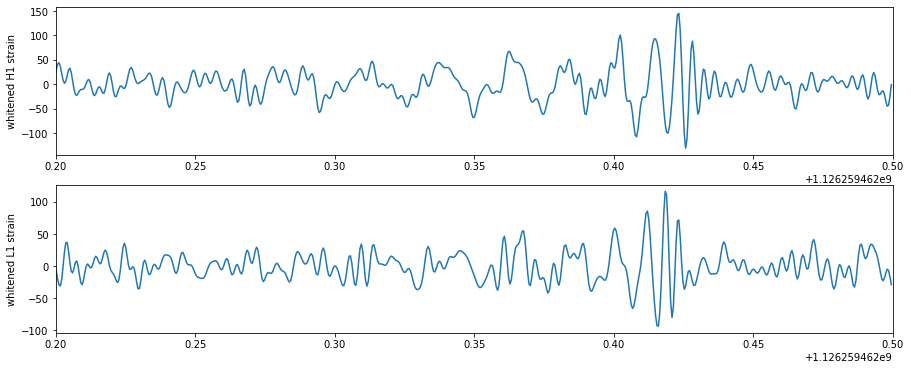

In [91]:
white_net_data = {}
for det in dets:
    white_net_data[det] = whiten_trim(strains[det], psd=psds[det])
    
fig, axs = plt.subplots(2, 1, figsize=(15, 6))
for ax, det in zip(axs, dets):
    ax.plot(white_net_data[det].sample_times, white_net_data[det])
    ax.set_ylabel('whitened {} strain'.format(det))
    ax.set_xlim(merger.time-.2, merger.time+.1)

In [92]:
var_names = ['m', 'ra', 'dec', 'distance', 'inclination', 'time', 'coa_phase', 'polarization']

def net_gen_template(theta,
                     dets=['H1', 'L1'],
                     delta_t=strains['H1'].delta_t,
                     duration=strains['H1'].duration,
                     start_time=strains['H1'].start_time,
                     f_lower=f_lower):
    m, ra, dec, distance, inclination, time, phase, polarization= theta
    
    hp, hc = get_td_waveform(approximant='SEOBNRv4_opt',
                             mass1=m,
                             mass2=m,
                             distance=distance,
                             inlination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)
    hp.resize(len(strains['H1']))
    hc.resize(len(strains['H1']))
    hp = hp.cyclic_time_shift(hp.start_time + time - start_time)
    hc = hc.cyclic_time_shift(hc.start_time + time - start_time)
    
    h = {}
    for det in dets:
        ifo = Detector(det)
        fp, fc = ifo.antenna_pattern(ra, dec, polarization, time)
        ifo_h = fp * hp + fc * hc
        dt = ifo.time_delay_from_earth_center(ra, dec, time)
        h[det] = ifo_h.cyclic_time_shift(dt)
        h[det].start_time = start_time
        
    return h

In [93]:
dfs = dict([(det, strain.to_frequencyseries()) for det, strain in strains.items()])

def net_loglikelihood(theta, dfs=dfs, psds=psds, f_lower=f_lower, f_upper=f_upper):
    dets = list(dfs.keys())
    logl = 0
    
    df = dfs[dets[0]]
    delta_t = df.delta_t
    duration = df.duration
    N = int(duration/delta_t)
    start_time = df.start_time
    
    try:
        hts = net_gen_template(theta, dets=dets, delta_t=delta_t,
                               duration=duration, start_time=start_time, f_lower=f_lower)
    except RuntimeError:
        return -np.inf
    
    for det, df in dfs.items():
        psd = psds[det]
        hf = hts[det].to_frequencyseries()
        
        kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)
        
        hh = np.array(4.0*df.delta_f*(hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax]).sum()
        dh = np.array(4.0*df.delta_f*(df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax]).sum()
        logl += -0.5 * (hh - 2.0*dh)
    return logl

In [94]:
theta0 = [36., 2.2, -1.2, 400., np.pi, float(merger.time)+.008, 0., 0.]
net_loglikelihood(theta0)

-783.6637778429497

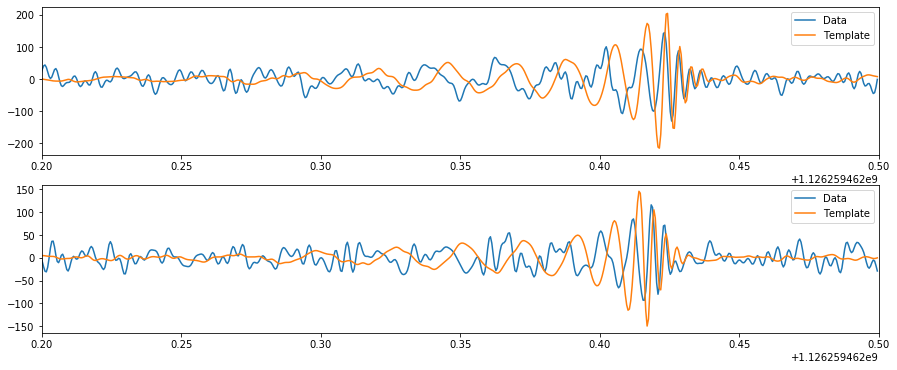

In [95]:
hts = net_gen_template(theta0)
fig, axs = plt.subplots(2, 1, figsize=[15, 6])

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim(hts[det], psds[det])
    ax.plot(white_net_data[det].sample_times, white_net_data[det], label='Data')
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label='Template')
    
    ax.set_xlim(merger.time - .2, merger.time + .1)
    ax.legend()


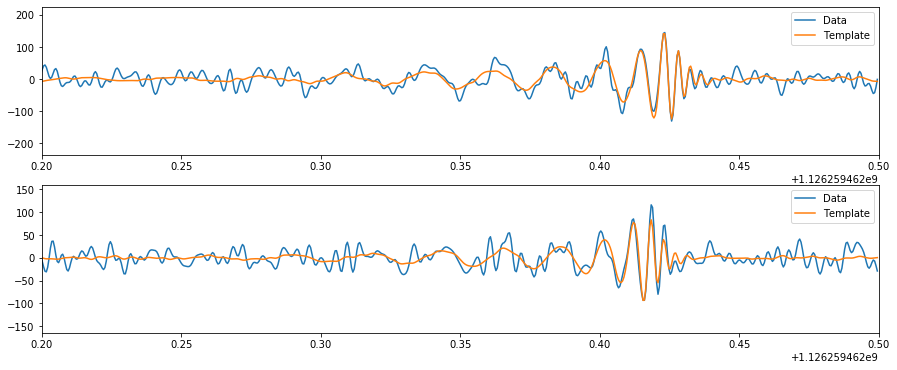

Steps	log(likelihood)
5	291.806


In [96]:
Neval = 1

fig, axs = plt.subplots(2, 1, figsize=[15, 6])

hts = net_gen_template(theta0)

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim(hts[det], psd=psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

def callback(thetai):
    global Neval
    global lines
    global fig
    
    templates = net_gen_template(thetai)
    for det in dets:
        white_template = whiten_trim(templates[det], psd=psds[det])
        lines[det].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, net_loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -net_loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

In [97]:
best_fit = res.x
best_fit_templates = net_gen_template(best_fit)

In [98]:
best_fit

array([ 3.68034044e+01,  2.26050016e+00, -1.11703061e+00,  6.41146902e+02,
        3.88510099e+01,  1.12625946e+09,  7.74011971e-02,  5.97525435e-03])

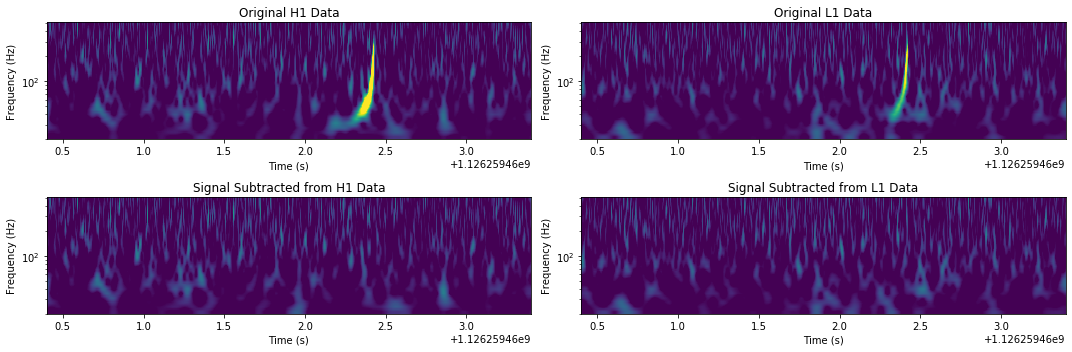

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))

for i, det in enumerate(dets):
    subtracted = strains[det] - best_fit_templates[det]

    # Plot the original data and the subtracted signal data
    for ax, data, title in [(axs[0][i], strains[det], 'Original {} Data'.format(det)),
                        (axs[1][i], subtracted, 'Signal Subtracted from {} Data'.format(det))]:

        t, f, p = data.whiten(4, 4).qtransform(.001,
                                              logfsteps=100,
                                              qrange=(8, 8),
                                              frange=(20, 512))
        ax.set_title(title)
        ax.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
        ax.set_yscale('log')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlim(merger.time - 2, merger.time + 1)
plt.tight_layout()

In [100]:
def logprior(theta):
    logp = 0
    

    m, ra, dec, distance, inclination, time, coa_phase, polarization=theta
    
    #uniform dist between 0 and 2pi
    for angle in [ra, coa_phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
        
    #uniform distance?
    if distance < 0:
        return -np.inf
    if inclination < 0 or inclination > np.pi:
        return -np.inf
    if dec < -np.pi/2 or dec >np.pi/2:
        return -np.inf
    
    logp += np.log(np.cos(dec))
    logp += 2 *np.log(distance)
    logp += np.log(np.sin(inclination))
    return logp
    

In [101]:
def logposterior(theta, **kwargs):
    logpost = logprior(theta)
    if np.isfinite(logpost):
        logpost += net_loglikelihood(theta)
        
    return logpost

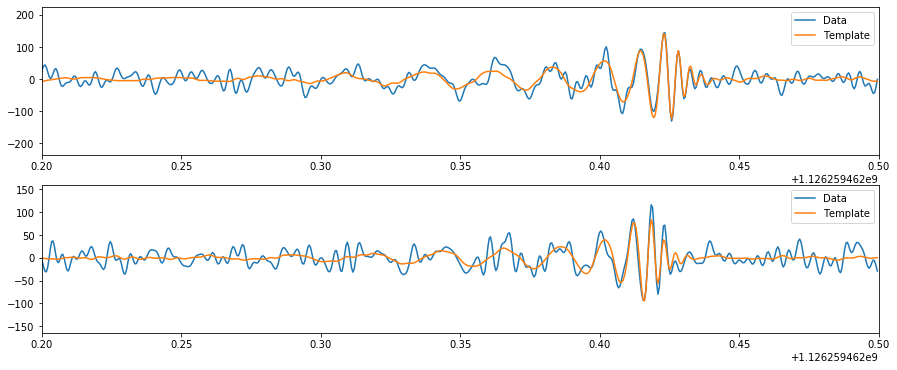

Steps	log(posterior)
8	304.570


In [102]:
Neval = 1

fig, axs = plt.subplots(2, 1, figsize=[15, 6])

hts = net_gen_template(theta0)

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim(hts[det], psd=psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

def callback(thetai):
    global Neval
    global lines
    global fig
    
    templates = net_gen_template(thetai)
    for det in dets:
        white_template = whiten_trim(templates[det], psd=psds[det])
        lines[det].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -logposterior(theta), theta0, callback=callback, method='powell')
plt.close()

In [103]:
MAP = res.x
print(MAP)

[ 3.67883344e+01  2.27403996e+00 -1.13446207e+00  6.48493526e+02
  1.57079633e+00  1.12625946e+09  4.93830422e-02  2.42894593e-03]


In [104]:
!pip uninstall -y emcee
!pip install emcee

Found existing installation: emcee 2.2.1
Uninstalling emcee-2.2.1:
  Successfully uninstalled emcee-2.2.1
     |████████████████████████████████| 41 kB 395 kB/s eta 0:00:01
ERROR: pycbc 1.16.1 has requirement emcee==2.2.1, but you'll have emcee 3.0.2 which is incompatible.


In [105]:
import emcee
print(emcee.__version__)

3.0.2


In [106]:
import os
os.environ['OMP_NUM_THREADS'] = "1"

In [108]:
nwalkers = 64

σm = 1.
σra = 0.05
σdec = 0.05
σdistance = 1.
σinclination = 0.05
σtime = .0001
σcoa_phase = .05
σpolarization = 0.05
ball_sigma = np.array([σm, σra, σdec, σdistance, σinclination, σtime, σcoa_phase, σpolarization])

In [109]:
ndim = len(MAP)
init = np.random.normal(MAP, ball_sigma, (nwalkers, ndim))
init_logp = np.array([logposterior(p) for p in init])
while np.any(np.isinf(init_logp)):
    sel = np.isinf(init_logp)
    print("{} bad points".format(np.sum(sel)))
    init[sel] = np.random.normal(MAP, ball_sigma, (np.sum(sel), ndim))
    init_logp[sel] = [logposterior(p) for p in init[sel]]

39 bad points
24 bad points
17 bad points
8 bad points
6 bad points
3 bad points
2 bad points
2 bad points
1 bad points
1 bad points


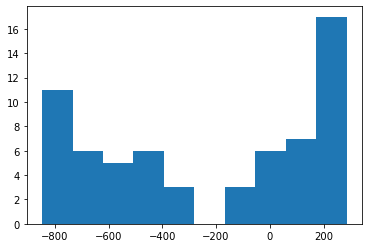

In [110]:
plt.hist(init_logp);


In [111]:
from multiprocessing import Pool

In [ ]:
nsteps=500

with Pool() as pool:
    sampler = emcee.Ensemble Sampler(nwalkers, ndim, logposterior, pool=pool)
    sampler.run_mcmc(init, nsteps, progress=True)